# Decision Tree & Random Forest for BOM Data

## Import Packages

In [2]:
import numpy as np
import pandas as pd
import datetime
import random
import sklearn

import seaborn as sns
import matplotlib.pyplot as plt
import datetime

# Ignore useless warnings 
import warnings
warnings.filterwarnings(action="ignore")                 

In [3]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree
from sklearn.preprocessing import StandardScaler
import sklearn.metrics as sm
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from prettytable import PrettyTable
import shap

In [4]:
import os
os.getcwd()

'/Users/danny/Desktop/MDS/master 4/CITS 5553 Data Science Capstone Project/Individual/Capstone-Individual/Data Modeling/Max_demand'

## Read Data

In [5]:
os.chdir('/Users/danny/Desktop/MDS/master 4/CITS 5553 Data Science Capstone Project/Individual/Capstone-Individual/Data')

In [8]:
df = pd.read_csv('demand_weather_date_daily.csv', index_col = 0)
df.head(100)

,Operational Demand (MW),Transpiration,Rain,Evaporation,Max Temp,Min Temp,Max Hum,Min Hum,Av Wind,Solar Rad,Year,month,Day_of_week,Day_of_month,Day_of_year,week_of_year,state_holiday,mnth_sin,mnth_cos
Date,,,,,,,,,,,,,,,,,,,
2009-01-01,2543.140,11.2,0.0,11.6,37.2,18.8,65,20,6.1,34.01,2009,1,3,1,1,1,True,0.0,1.000000e+00
2009-01-02,2893.868,10.2,0.0,12.8,36.1,21.9,70,25,5.31,34.25,2009,1,4,2,2,1,False,0.0,1.000000e+00
2009-01-03,2450.920,9.4,0.0,11.8,34.4,20.3,79,29,5.45,34.11,2009,1,5,3,3,1,False,0.0,1.000000e+00
2009-01-04,2526.302,10.5,0.0,11.2,36.5,18.5,62,20,5.25,34.05,2009,1,6,4,4,1,False,0.0,1.000000e+00
2009-01-05,3106.014,11.9,0.0,11.4,37.2,21.8,63,17,6.77,34.18,2009,1,0,5,5,2,False,0.0,1.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2009-04-06,2294.836,7.6,0.0,8.4,29.2,14.7,64,17,6.36,22.32,2009,4,0,6,96,15,False,1.0,6.123234e-17
2009-04-07,2439.914,7.1,0.0,7.4,31.6,17.2,52,16,4.54,22.04,2009,4,1,7,97,15,False,1.0,6.123234e-17
2009-04-08,2544.262,7.3,0.0,7.4,33.6,17.4,55,11,4.44,20.64,2009,4,2,8,98,15,False,1.0,6.123234e-17


## Data Cleaning

In [9]:
# numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
# numeric = []
# for i in df.columns:
#     if df[i].dtype not in numeric_dtypes:
#         df[i]=df[i].str.replace(" ",'') # Replace all ' ' into none
#         df[i]=pd.to_numeric(df[i])

AttributeError: Can only use .str accessor with string values!

In [11]:
df.columns

Index(['Operational Demand (MW)', 'Transpiration', 'Rain', 'Evaporation',
       'Max Temp', 'Min Temp', 'Max Hum', 'Min Hum', 'Av Wind', 'Solar Rad',
       'Year', 'month', 'Day_of_week', 'Day_of_month', 'Day_of_year',
       'week_of_year', 'state_holiday', 'mnth_sin', 'mnth_cos'],
      dtype='object')

In [12]:
df.index = pd.to_datetime(df.index,format= '%Y-%m-%d')
# df.index = pd.to_datetime(df.index,format= '%d/%m/%Y')
select_col=['Operational Demand (MW)', 'Transpiration', 'Rain', 'Evaporation',
       'Max Temp', 'Min Temp', 'Max Hum', 'Min Hum', 'Av Wind', 'Solar Rad',
       'Year', 'month', 'Day_of_week', 'Day_of_month', 'Day_of_year',
       'week_of_year', 'state_holiday', 'mnth_sin', 'mnth_cos']
y_col=['Operational Demand (MW)']
x_col=list(set(select_col)-set(y_col))

model_df=df[select_col].fillna(method='ffill',axis=0)
test_dat = model_df[(model_df.index >= '2021-12-01') & ('2022-04-01' > model_df.index)]
training_dat = model_df[model_df.index < '2021-12-01']

# training_dat = model_df[(model_df.index < '2021-12-01') | ('2022-04-01' <= model_df.index)]

In [13]:
X_train = training_dat.drop('Operational Demand (MW)',axis=1)
y_train = training_dat['Operational Demand (MW)']

X_test = test_dat.drop('Operational Demand (MW)', axis = 1) 
y_test = test_dat['Operational Demand (MW)']

## Function Create

In [14]:
def ImportanceDisplay(model):
    if 'grid' in model:
        impo_lst=[model,'.best_estimator_.feature_importances_']
    else:
        impo_lst=[model,'.feature_importances_']
    impo_str=''
    importance = eval(impo_str.join(impo_lst))
    #importance = rf_reg.feature_importances_
    table = PrettyTable(['Factors','Score'])
    for i,v in enumerate(importance):
	    table.add_row([x_col[i],round(v,4)])
    print(table)
def ModelScore(true,predict):
    print("Mean absolute error = ",round(sm.mean_absolute_error(true,predict),4))
    print("Mean squared error = ",round(sm.mean_squared_error(true,predict),4))
    print("Median absolute error = ",round(sm.median_absolute_error(true,predict),4))
    print("explained variance error = ",round(sm.explained_variance_score(true,predict),4))
    print("R2 error = ",round(sm.r2_score(true,predict),4))

## Threshold Determine

3405.0686666666666

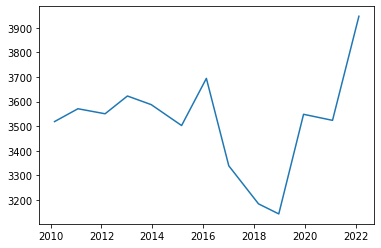

In [35]:
new_df_summer = pd.DataFrame()
for i in range(2009,2022):
    s0 = str(i) + '-12-01'
    s1 = str(i+1) + '-04-01'
    df_summer = model_df[(model_df.index >= s0) & (s1 > model_df.index)]
    order_table = df_summer.sort_values('Operational Demand (MW)',ascending=False)
    nr = order_table[4:5]
    new_df_summer = pd.concat((new_df_summer,nr))
od = new_df_summer['Operational Demand (MW)']
plt.plot(od.index,od)
year_choose = 3 # number of year we choose to get the average threshold
ave_threshold = sum(od[-4:-1])/year_choose
# ave_threshold= sum(od[:-1])/len(od[:-1])
ave_threshold


In [16]:
od

Date
2010-03-12    3560.812
2011-02-24    3628.322
2012-02-01    3571.344
2013-02-20    3641.666
2014-01-23    3609.438
2015-02-24    3522.062
2016-02-10    3795.442
2017-03-03    3368.454
2018-02-15    3202.462
2019-01-20    3154.918
2020-02-14    3571.626
2021-02-23    3536.800
2022-01-21    3947.946
Name: Operational Demand (MW), dtype: float64

## Decision Tree

In [19]:
tree_reg = DecisionTreeRegressor(random_state=42)

param_grid_dtree = dict(
    max_depth =[None,15,20,25],
    min_samples_leaf=[5,50,100])

grid_dtree=GridSearchCV(tree_reg, param_grid_dtree, cv=3, scoring='neg_root_mean_squared_error',verbose=2,return_train_score=True)

grid_dtree.fit(X_train,y_train)
y_pred_tree = grid_dtree.predict(X_test)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] END .................max_depth=None, min_samples_leaf=5; total time=   0.0s
[CV] END .................max_depth=None, min_samples_leaf=5; total time=   0.0s
[CV] END .................max_depth=None, min_samples_leaf=5; total time=   0.0s
[CV] END ................max_depth=None, min_samples_leaf=50; total time=   0.0s
[CV] END ................max_depth=None, min_samples_leaf=50; total time=   0.0s
[CV] END ................max_depth=None, min_samples_leaf=50; total time=   0.0s
[CV] END ...............max_depth=None, min_samples_leaf=100; total time=   0.0s
[CV] END ...............max_depth=None, min_samples_leaf=100; total time=   0.0s
[CV] END ...............max_depth=None, min_samples_leaf=100; total time=   0.0s
[CV] END ...................max_depth=15, min_samples_leaf=5; total time=   0.0s
[CV] END ...................max_depth=15, min_samples_leaf=5; total time=   0.0s
[CV] END ...................max_depth=15, min_sa

In [20]:
dtscore=ModelScore(y_test,y_pred_tree)
dtscore
ny_test=len(y_test)
mape = (sum(np.abs((y_test - y_pred_tree)/y_test))/ny_test)*100
print('Mape', mape)
ImportanceDisplay('grid_dtree')
print(grid_dtree.best_estimator_)

Mean absolute error =  230.3513
Mean squared error =  87293.5736
Median absolute error =  183.876
explained variance error =  0.8463
R2 error =  0.6817
Mape 7.206277709032663
+---------------+--------+
|    Factors    | Score  |
+---------------+--------+
|    Av Wind    | 0.0026 |
|   Solar Rad   | 0.0016 |
|      Year     | 0.0092 |
| Transpiration | 0.5909 |
|    mnth_sin   | 0.0833 |
|  Day_of_week  | 0.0054 |
|    Min Temp   | 0.0049 |
|  week_of_year | 0.0056 |
|    Max Temp   | 0.0068 |
|  Day_of_month | 0.0617 |
|    mnth_cos   |  0.0   |
|      Rain     | 0.0891 |
|     month     | 0.0061 |
|    Min Hum    | 0.0533 |
| state_holiday | 0.0102 |
|    Max Hum    | 0.0068 |
|  Day_of_year  | 0.0033 |
|  Evaporation  | 0.0592 |
+---------------+--------+
DecisionTreeRegressor(max_depth=15, min_samples_leaf=5, random_state=42)


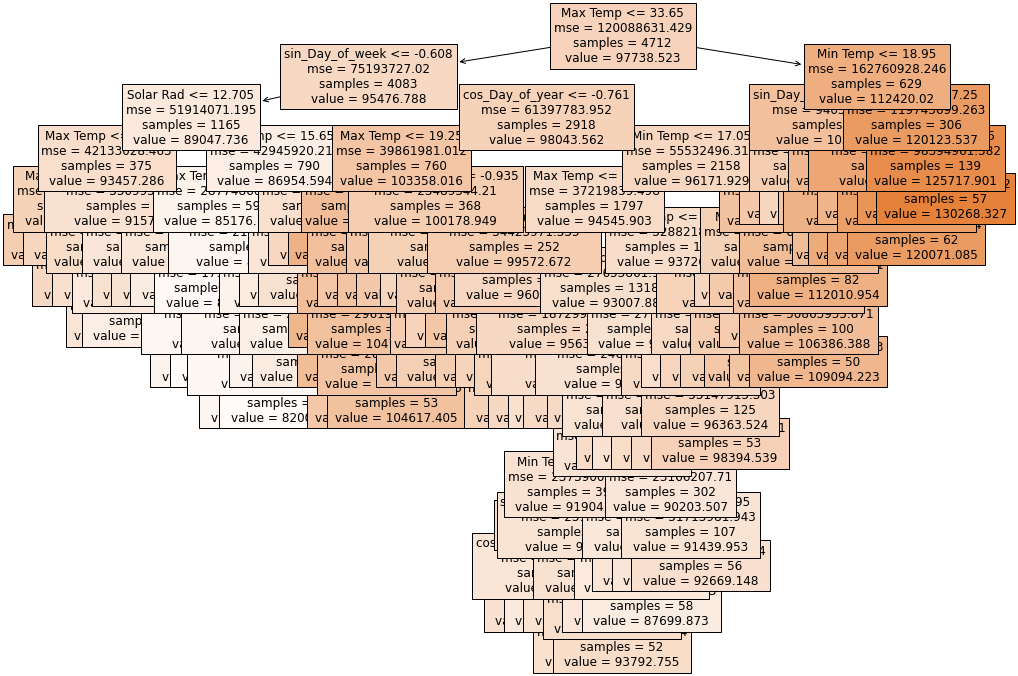

In [14]:
fig = plt.figure(figsize=(16,12))
a_rf_smote = plot_tree(grid_dtree.best_estimator_, feature_names=X_train.columns, fontsize=12, filled=True, class_names=['0', '1'])

In [21]:
y_pred_tree = pd.DataFrame(y_pred_tree)
predict_table_dt = pd.DataFrame(y_test)
predict_table_dt.insert(1,'predict',y_pred_tree)
predict_table_dt

,Operational Demand (MW),predict
Date,,
2021-12-01,2316.044,2296.894000
2021-12-02,2419.212,2296.894000
2021-12-03,2535.248,2614.399000
2021-12-04,2490.794,2394.356667
2021-12-05,2415.468,2536.400000
...,...,...
2022-03-27,2420.366,2342.980857
2022-03-28,2595.430,2594.942800
2022-03-29,2756.346,2896.099143


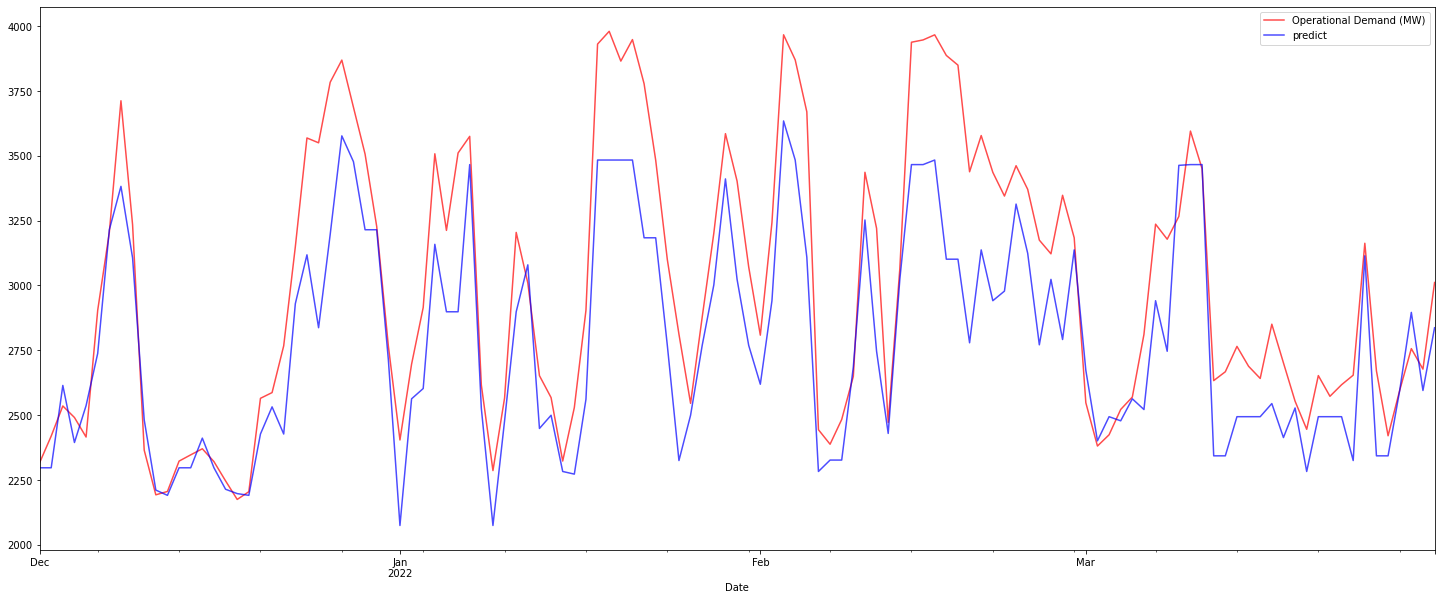

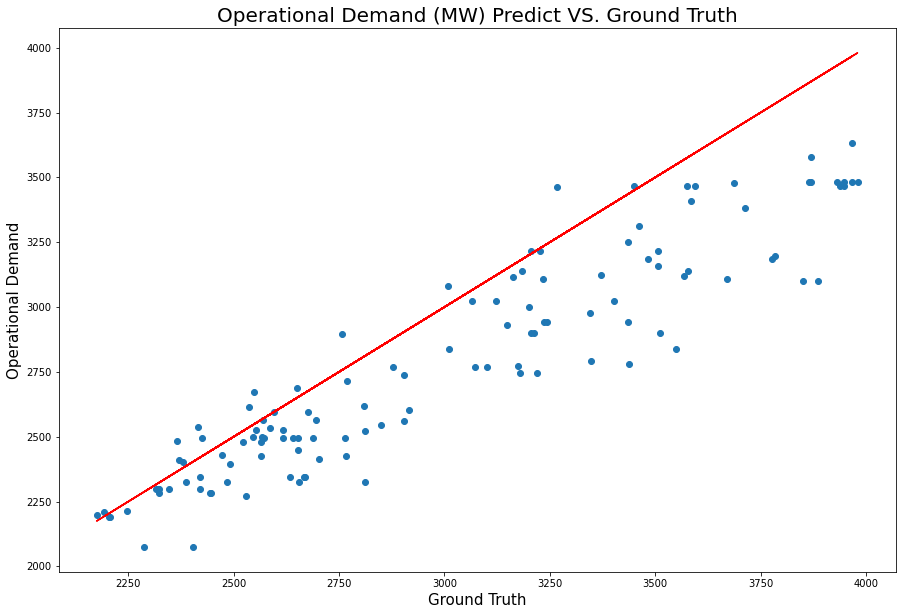

In [22]:
predict_table_dt.plot.line(figsize = (25,10), color = ['red','blue'],alpha = 0.7)
plt.show()
plt.figure(figsize=(15,10))
plt.scatter(predict_table_dt['Operational Demand (MW)'], predict_table_dt['predict'])
plt.plot(predict_table_dt['Operational Demand (MW)'],predict_table_dt['Operational Demand (MW)'], c= 'red')
plt.xlabel('Ground Truth',fontsize = 15)
plt.ylabel("Operational Demand", fontsize = 15)
plt.title("Operational Demand (MW) Predict VS. Ground Truth", fontsize = 20)
plt.show()

In [23]:
peak_day = 5 # number of top peak day we choose
peak_true = predict_table_dt.sort_values('Operational Demand (MW)',ascending=False)[:peak_day]
truelst = peak_true.index.tolist()
# peak_predict = predict_table_dt.sort_values('predict',ascending=False)[:peak_day]
peak_predict = predict_table_dt[predict_table_dt['predict'] > ave_threshold]
predictlst=peak_predict.index.tolist()
acc = len([x for x in truelst if x in predictlst])/peak_day
print('Accuracy for predicting peak 5 day:',acc)

Accuracy for predicting peak 5 day: 0.2


## Random Forest

In [25]:
forest = RandomForestRegressor(random_state=42)

param_grid_forest = dict(
    max_depth =[None,15,20,25],
    min_samples_leaf=[5,50,100])

grid_forest=GridSearchCV(forest, param_grid_forest, cv=3, scoring='neg_root_mean_squared_error',verbose=2,return_train_score=True)

grid_forest.fit(X_train, y_train)
y_predict_forest = grid_forest.predict(X_test)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] END .................max_depth=None, min_samples_leaf=5; total time=   1.4s
[CV] END .................max_depth=None, min_samples_leaf=5; total time=   1.4s
[CV] END .................max_depth=None, min_samples_leaf=5; total time=   1.3s
[CV] END ................max_depth=None, min_samples_leaf=50; total time=   0.8s
[CV] END ................max_depth=None, min_samples_leaf=50; total time=   0.8s
[CV] END ................max_depth=None, min_samples_leaf=50; total time=   0.8s
[CV] END ...............max_depth=None, min_samples_leaf=100; total time=   0.6s
[CV] END ...............max_depth=None, min_samples_leaf=100; total time=   0.6s
[CV] END ...............max_depth=None, min_samples_leaf=100; total time=   0.7s
[CV] END ...................max_depth=15, min_samples_leaf=5; total time=   1.3s
[CV] END ...................max_depth=15, min_samples_leaf=5; total time=   1.3s
[CV] END ...................max_depth=15, min_sa

In [26]:
rfscore=ModelScore(y_test,y_predict_forest)
rfscore
mape = (sum(np.abs((y_test - y_predict_forest)/y_test))/ny_test)*100
print('Mape', mape)
ImportanceDisplay('grid_forest')
print(grid_forest.best_estimator_)

Mean absolute error =  210.6921
Mean squared error =  72435.7456
Median absolute error =  177.256
explained variance error =  0.8853
R2 error =  0.7359
Mape 6.486409663357624
+---------------+--------+
|    Factors    | Score  |
+---------------+--------+
|    Av Wind    | 0.0049 |
|   Solar Rad   | 0.0013 |
|      Year     | 0.0073 |
| Transpiration | 0.583  |
|    mnth_sin   | 0.0836 |
|  Day_of_week  | 0.0049 |
|    Min Temp   | 0.0078 |
|  week_of_year | 0.008  |
|    Max Temp   | 0.0194 |
|  Day_of_month | 0.0577 |
|    mnth_cos   | 0.0008 |
|      Rain     | 0.0899 |
|     month     | 0.0053 |
|    Min Hum    | 0.0415 |
| state_holiday | 0.0149 |
|    Max Hum    | 0.0055 |
|  Day_of_year  | 0.0029 |
|  Evaporation  | 0.0613 |
+---------------+--------+
RandomForestRegressor(max_depth=20, min_samples_leaf=5, random_state=42)


In [28]:
y_predict_forest = pd.DataFrame(y_predict_forest)
predict_table_rf = pd.DataFrame(y_test)
predict_table_rf.insert(1,'predict',y_predict_forest)
predict_table_rf

,Operational Demand (MW),predict
Date,,
2021-12-01,2316.044,2305.663296
2021-12-02,2419.212,2360.708357
2021-12-03,2535.248,2545.280915
2021-12-04,2490.794,2395.783474
2021-12-05,2415.468,2546.660137
...,...,...
2022-03-27,2420.366,2359.098299
2022-03-28,2595.430,2451.834833
2022-03-29,2756.346,2723.835421


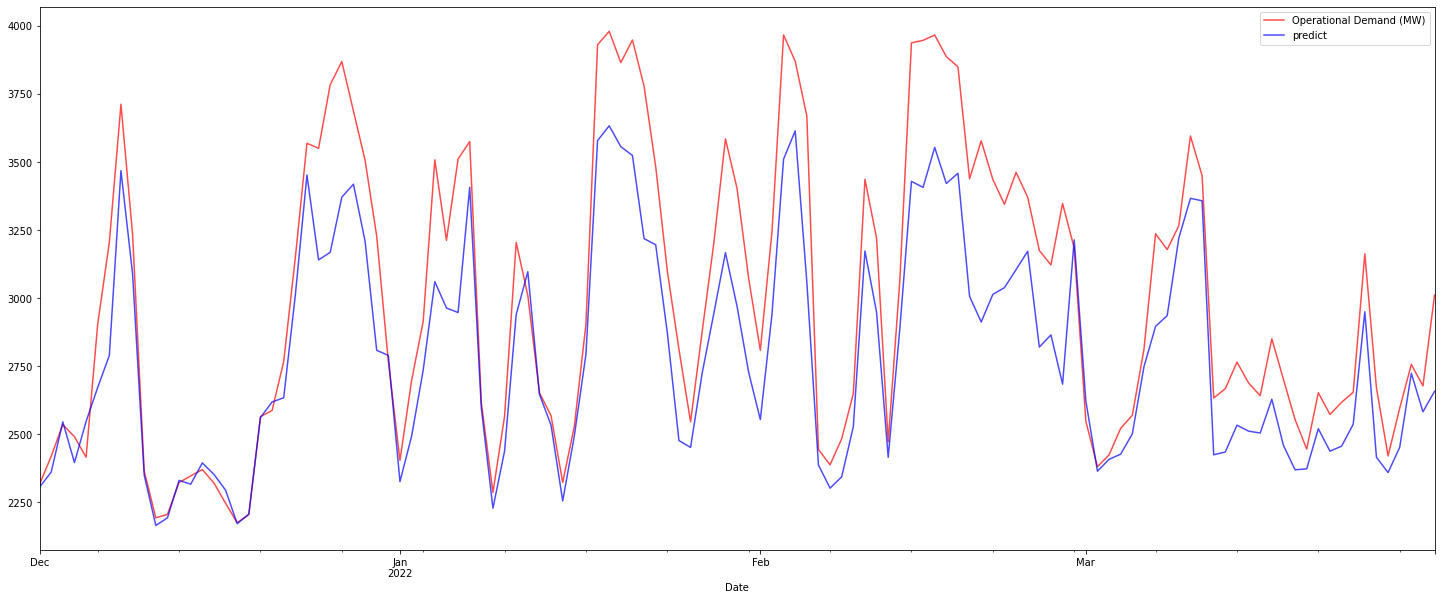

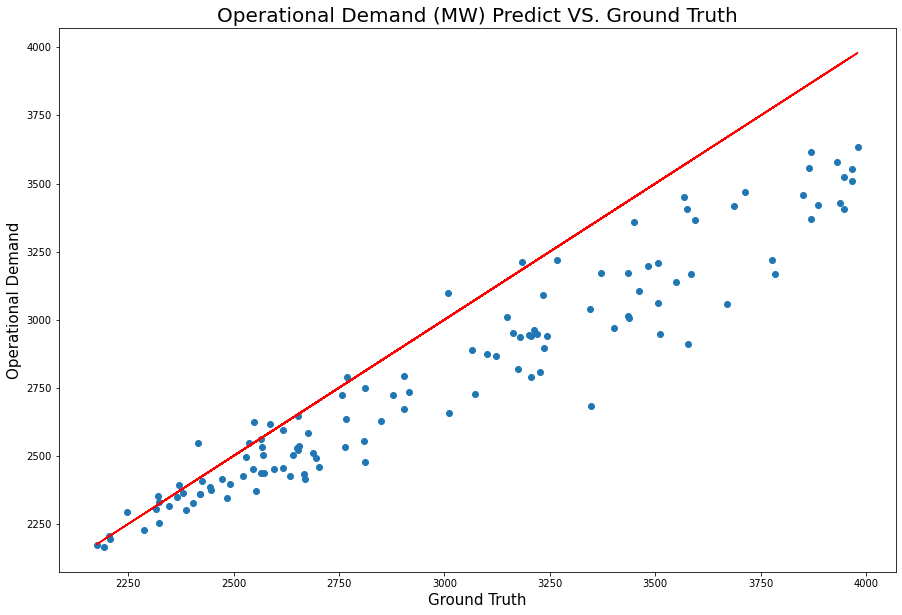

In [29]:
predict_table_rf.plot.line(figsize = (25,10), color = ['red','blue'],alpha = 0.7)
plt.show()
plt.figure(figsize=(15,10))
plt.scatter(predict_table_rf['Operational Demand (MW)'], predict_table_rf['predict'])
plt.plot(predict_table_rf['Operational Demand (MW)'],predict_table_rf['Operational Demand (MW)'], c= 'red')
plt.xlabel('Ground Truth',fontsize = 15)
plt.ylabel("Operational Demand", fontsize = 15)
plt.title("Operational Demand (MW) Predict VS. Ground Truth", fontsize = 20)
plt.show()

In [22]:
# peak_day = predict_table[predict_table['predict'] >= ave_threshold]
# peak_day

In [36]:
peak_day = 5 # number of top peak day we choose
peak_true = predict_table_rf.sort_values('Operational Demand (MW)',ascending=False)[:peak_day]
truelst = peak_true.index.tolist()
# peak_predict = predict_table_rf.sort_values('predict',ascending=False)[:peak_day]
peak_predict = predict_table_rf[predict_table_rf['predict'] > ave_threshold]
predictlst=peak_predict.index.tolist()
acc = len([x for x in truelst if x in predictlst])/peak_day
print('Accuracy for predicting peak 5 day:',acc)

Accuracy for predicting peak 5 day: 1.0


In [31]:
peak_predict

,Operational Demand (MW),predict
Date,,
2022-01-18,3930.628,3578.420797
2022-01-19,3979.836,3632.845077
2022-01-20,3865.000,3556.226435
2022-01-21,3947.946,3523.781019
2022-02-04,3869.702,3614.063328
2022-02-16,3966.284,3553.376435


In [32]:
peak_true

,Operational Demand (MW),predict
Date,,
2022-01-19,3979.836,3632.845077
2022-02-03,3966.438,3510.476667
2022-02-16,3966.284,3553.376435
2022-01-21,3947.946,3523.781019
2022-02-15,3946.592,3406.606815


## SHAP Explain

In [25]:
shap.initjs()
row_choose = 3
explainer = shap.TreeExplainer(grid_forest.best_estimator_)
shap_values = explainer.shap_values(X_test)
shap.force_plot(explainer.expected_value, shap_values[row_choose], X_test.iloc[row_choose])

In [26]:
shap.force_plot(explainer.expected_value, shap_values,X_test)

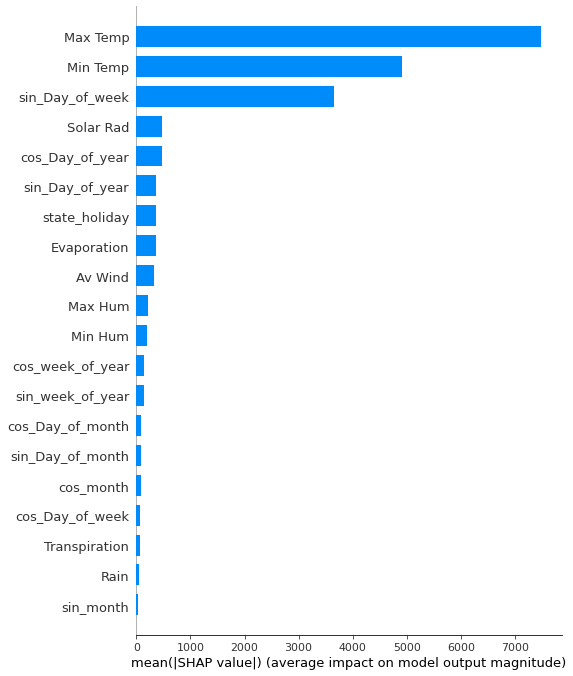

In [27]:
shap_values = shap.TreeExplainer(grid_forest.best_estimator_).shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_type="bar")

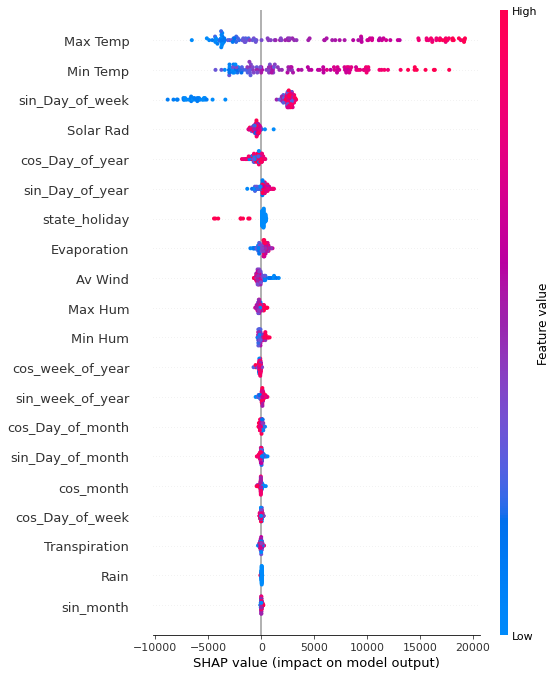

In [28]:
shap.summary_plot(shap_values, X_test)

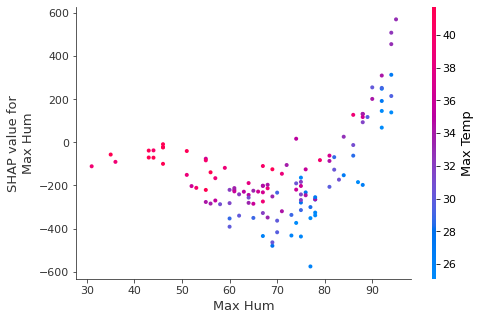

In [29]:
# Part
shap.dependence_plot('Max Hum', shap_values, X_test)